# Mercari Price Suggestion GBM Classifier with Structured Data

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pdb
import re
import pickle
import string
import pandas as pd
import numpy as np
import lightgbm as lgb
np.set_printoptions(precision=4)

from wordcloud import WordCloud
from sklearn.metrics import mean_squared_error

from pathlib import Path

from utils.data_utils import set_two_splits
from utils.plots import *

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
from args import args
vars(args)

{'path': PosixPath('data'),
 'workdir': PosixPath('data/workdir'),
 'train_tsv': PosixPath('data/train.tsv'),
 'test_tsv': PosixPath('data/test.tsv'),
 'test2_tsv': PosixPath('data/test_stg2.tsv'),
 'modeldir': PosixPath('data/workdir/models'),
 'figdir': PosixPath('data/workdir/figures')}

In [34]:
save = True

## Functions

## Train and Validation

In [13]:
str_cols = ['item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2']

str_df = pd.read_csv(args.path/'train_df.csv', usecols=str_cols+['price'])
str_df.head()

,item_condition_id,brand_name,price,shipping,main_cat,sub_cat1,sub_cat2
0,3,missing,2.397895,1,Men,Tops,T-shirts
1,3,Razer,3.970292,0,Electronics,Computers & Tablets,Components & Parts
2,1,Target,2.397895,1,Women,Tops & Blouses,Blouse
3,1,missing,3.583519,1,Home,Home Décor,Home Décor Accents
4,1,missing,3.806662,0,Women,Jewelry,Necklaces


In [16]:
seed = 643
df = set_two_splits(str_df.copy(), 'valid', seed=seed)
train_df = df.loc[df['split'] == 'train', str_cols+['price']].reset_index(drop=True)
valid_df = df.loc[df['split'] == 'valid', str_cols+['price']].reset_index(drop=True)
y_train = train_df['price']
y_valid = valid_df['price']

df.shape, train_df.shape, valid_df.shape, y_train.shape, y_valid.shape

((1462949, 8), (1243506, 7), (219443, 7), (1243506,), (219443,))

In [19]:
brands = train_df.groupby('brand_name')['price'].mean().sort_values(ascending=False).to_frame()
brands['id'] = brands.reset_index().index.values
brand_names = brands.index.values

train_brand_data = brands.loc[train_df['brand_name']]
train_df.loc[:, 'brand_val'] = train_brand_data['id'].values/len(brand_names)

valid_brand_data = brands.loc[valid_df['brand_name']]
valid_df.loc[:, 'brand_val'] = valid_brand_data['id'].values/len(brand_names)

maincats = train_df.groupby('main_cat')['price'].mean().sort_values(ascending=False).to_frame()
maincats['id'] = maincats.reset_index().index.values
maincat_names = maincats.index.values

train_maincats = maincats.loc[train_df['main_cat']]
train_df.loc[:, 'maincat_val'] = train_maincats['id'].values/len(maincat_names)

valid_maincats = maincats.loc[valid_df['main_cat']]
valid_df.loc[:, 'maincat_val'] = valid_maincats['id'].values/len(maincat_names)

subcat1s = train_df.groupby('sub_cat1')['price'].mean().sort_values(ascending=False).to_frame()
subcat1s['id'] = subcat1s.reset_index().index.values
subcat1_names = subcat1s.index.values

train_subcat1s = subcat1s.loc[train_df['sub_cat1']]
train_df.loc[:, 'subcat1_val'] = train_subcat1s['id'].values/len(subcat1_names)

valid_subcat1s = subcat1s.loc[valid_df['sub_cat1']]
valid_df.loc[:, 'subcat1_val'] = valid_subcat1s['id'].values/len(subcat1_names)

subcat2s = train_df.groupby('sub_cat2')['price'].mean().sort_values(ascending=False).to_frame()
subcat2s['id'] = subcat2s.reset_index().index.values
subcat2_names = subcat2s.index.values

train_subcat2s = subcat2s.loc[train_df['sub_cat2']]
train_df.loc[:, 'subcat2_val'] = train_subcat2s['id'].values/len(subcat2_names)

valid_subcat2s = subcat2s.loc[valid_df['sub_cat2']]
valid_df.loc[:, 'subcat2_val'] = valid_subcat2s['id'].values/len(subcat2_names)

/storage/anaconda3/envs/phd/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [25]:
x_train = train_df[['item_condition_id', 'shipping', 'brand_val', 'maincat_val', 'subcat1_val', 'subcat2_val']].values

x_valid = valid_df[['item_condition_id', 'shipping', 'brand_val', 'maincat_val', 'subcat1_val', 'subcat2_val']].values

In [26]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

lgb_params = {
  'num_leaves': 400,
  'learning_rate': 0.05,
  'feature_fraction': 0.9,
  'bagging_fraction': 0.7,
  'bagging_freq': 5,
  'metric': 'rmse',
  'num_threads': 32,
  'max_bin': 32,
  'objective': 'regression',
}

In [28]:
gbm = lgb.train(lgb_params, lgb_train, num_boost_round=600, valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=10, verbose_eval=True)

[1]	training's rmse: 0.713949	valid_1's rmse: 0.713133
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 0.700567	valid_1's rmse: 0.699923
[3]	training's rmse: 0.691071	valid_1's rmse: 0.690537
[4]	training's rmse: 0.679429	valid_1's rmse: 0.679075
[5]	training's rmse: 0.668138	valid_1's rmse: 0.667974
[6]	training's rmse: 0.660695	valid_1's rmse: 0.660631
[7]	training's rmse: 0.651309	valid_1's rmse: 0.65142
[8]	training's rmse: 0.642272	valid_1's rmse: 0.642567
[9]	training's rmse: 0.63434	valid_1's rmse: 0.634793
[10]	training's rmse: 0.626707	valid_1's rmse: 0.627334
[11]	training's rmse: 0.620362	valid_1's rmse: 0.621102
[12]	training's rmse: 0.61458	valid_1's rmse: 0.61543
[13]	training's rmse: 0.608799	valid_1's rmse: 0.609802
[14]	training's rmse: 0.603203	valid_1's rmse: 0.604356
[15]	training's rmse: 0.598139	valid_1's rmse: 0.599446
[16]	training's rmse: 0.593536	valid_1's rmse: 0.594984
[17]	training's rmse: 0.589448	valid_1's rmse: 0.591031


[148]	training's rmse: 0.537177	valid_1's rmse: 0.542926
[149]	training's rmse: 0.537149	valid_1's rmse: 0.542904
[150]	training's rmse: 0.537122	valid_1's rmse: 0.542883
[151]	training's rmse: 0.537096	valid_1's rmse: 0.54287
[152]	training's rmse: 0.537056	valid_1's rmse: 0.542844
[153]	training's rmse: 0.537021	valid_1's rmse: 0.54282
[154]	training's rmse: 0.536998	valid_1's rmse: 0.542809
[155]	training's rmse: 0.536973	valid_1's rmse: 0.542788
[156]	training's rmse: 0.536938	valid_1's rmse: 0.542762
[157]	training's rmse: 0.536907	valid_1's rmse: 0.542744
[158]	training's rmse: 0.536887	valid_1's rmse: 0.542729
[159]	training's rmse: 0.536861	valid_1's rmse: 0.542714
[160]	training's rmse: 0.536842	valid_1's rmse: 0.542698
[161]	training's rmse: 0.536816	valid_1's rmse: 0.542689
[162]	training's rmse: 0.536788	valid_1's rmse: 0.542674
[163]	training's rmse: 0.536765	valid_1's rmse: 0.542662
[164]	training's rmse: 0.536741	valid_1's rmse: 0.542654
[165]	training's rmse: 0.536719	v

[293]	training's rmse: 0.534747	valid_1's rmse: 0.541805
[294]	training's rmse: 0.534738	valid_1's rmse: 0.541801
[295]	training's rmse: 0.534731	valid_1's rmse: 0.541798
[296]	training's rmse: 0.53472	valid_1's rmse: 0.541795
[297]	training's rmse: 0.534712	valid_1's rmse: 0.541791
[298]	training's rmse: 0.534705	valid_1's rmse: 0.541789
[299]	training's rmse: 0.534692	valid_1's rmse: 0.541787
[300]	training's rmse: 0.53468	valid_1's rmse: 0.541783
[301]	training's rmse: 0.534667	valid_1's rmse: 0.541782
[302]	training's rmse: 0.534659	valid_1's rmse: 0.541782
[303]	training's rmse: 0.534644	valid_1's rmse: 0.541776
[304]	training's rmse: 0.534637	valid_1's rmse: 0.541778
[305]	training's rmse: 0.53463	valid_1's rmse: 0.541776
[306]	training's rmse: 0.534619	valid_1's rmse: 0.541773
[307]	training's rmse: 0.534605	valid_1's rmse: 0.541768
[308]	training's rmse: 0.534593	valid_1's rmse: 0.541762
[309]	training's rmse: 0.534582	valid_1's rmse: 0.541756
[310]	training's rmse: 0.534574	va

In [29]:
fn = ['item_condition_id', 'shipping', 'brand_name', 'main_cat', 'sub_cat1', 'sub_cat2']

n_features=20

fi = gbm.feature_importance(importance_type='gain')
idxs = np.argsort(fi)

p = re.compile('^[a-z\s]+$')
features = []
fidxs = []
for i in idxs:
  feature = fn[i]
  if 'token_' not in feature:
    features.append(fn[i])
    fidxs.append(i)
fidxs = np.array(fidxs)        
fi = fi[fidxs]
fi = fi/fi.max()

fi_df = pd.DataFrame({'feature': features, 'importance': fi}).sort_values('importance', ascending=False).reset_index(drop=True)
plot_df = fi_df.head(n_features)

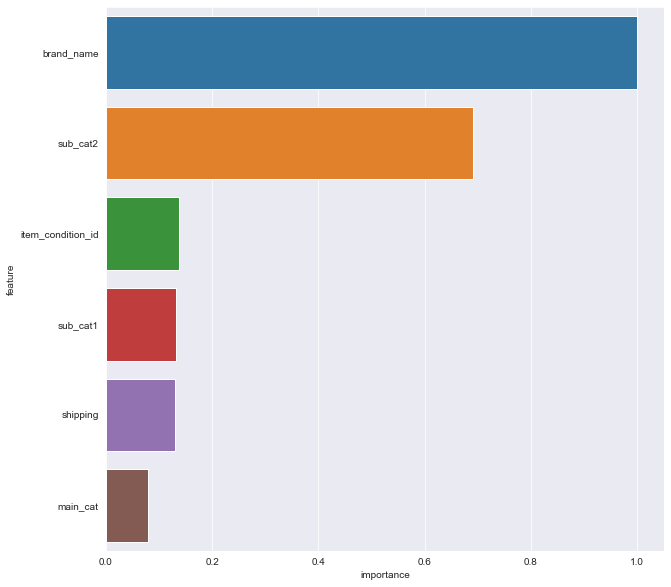

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=plot_df, ci=None)

if save:
  fig.savefig(args.figdir/'fi_full.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [36]:
preds = gbm.predict(x_valid)
np.round(np.sqrt(mean_squared_error(y_valid, preds)), 3)

0.542

## Full Model Training

In [37]:
str_cols = ['item_condition_id', 'brand_name', 'shipping', 'main_cat', 'sub_cat1', 'sub_cat2']
train_df = pd.read_csv(args.path/'train_df.csv', usecols=str_cols+['price'])

,item_condition_id,brand_name,price,shipping,main_cat,sub_cat1,sub_cat2
0,3,missing,2.397895,1,Men,Tops,T-shirts
1,3,Razer,3.970292,0,Electronics,Computers & Tablets,Components & Parts
2,1,Target,2.397895,1,Women,Tops & Blouses,Blouse
3,1,missing,3.583519,1,Home,Home Décor,Home Décor Accents
4,1,missing,3.806662,0,Women,Jewelry,Necklaces


In [38]:
brands = train_df.groupby('brand_name')['price'].mean().sort_values(ascending=False).to_frame()
brands['id'] = brands.reset_index().index.values
brand_names = brands.index.values

train_brand_data = brands.loc[train_df['brand_name']]
train_df.loc[:, 'brand_val'] = train_brand_data['id'].values/len(brand_names)

maincats = train_df.groupby('main_cat')['price'].mean().sort_values(ascending=False).to_frame()
maincats['id'] = maincats.reset_index().index.values
maincat_names = maincats.index.values

train_maincats = maincats.loc[train_df['main_cat']]
train_df.loc[:, 'maincat_val'] = train_maincats['id'].values/len(maincat_names)

subcat1s = train_df.groupby('sub_cat1')['price'].mean().sort_values(ascending=False).to_frame()
subcat1s['id'] = subcat1s.reset_index().index.values
subcat1_names = subcat1s.index.values

train_subcat1s = subcat1s.loc[train_df['sub_cat1']]
train_df.loc[:, 'subcat1_val'] = train_subcat1s['id'].values/len(subcat1_names)

subcat2s = train_df.groupby('sub_cat2')['price'].mean().sort_values(ascending=False).to_frame()
subcat2s['id'] = subcat2s.reset_index().index.values
subcat2_names = subcat2s.index.values

train_subcat2s = subcat2s.loc[train_df['sub_cat2']]
train_df.loc[:, 'subcat2_val'] = train_subcat2s['id'].values/len(subcat2_names)

In [39]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_params = {
  'num_leaves': 400,
  'learning_rate': 0.05,
  'feature_fraction': 0.9,
  'bagging_fraction': 0.7,
  'bagging_freq': 5,
  'metric': 'rmse',
  'num_threads': 32,
  'max_bin': 32,
  'objective': 'regression',
}

In [ ]:
gbm = lgb.train(lgb_params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train], early_stopping_rounds=10, verbose_eval=True)

## Test

In [ ]:
test_df = pd.read_csv(args.path/'test_df.csv', usecols=['test_id', 'text'])
x_test = vectorizer.transform(test_df['text'].values.astype('U'))
preds = pd.DataFrame({'test_id': test_df['test_id'], 'price': np.expm1(gbm.predict(x_test))})
preds.to_csv(args.path/'gbm_desc_submission.csv', index=False)

In [ ]:
test2_df = pd.read_csv(args.path/'test2_df.csv', usecols=['test_id', 'text'])
x_test2 = vectorizer.transform(test2_df['text'].values.astype('U'))
preds_test2 = pd.DataFrame({'test_id': test2_df['test_id'], 'price': np.expm1(gbm.predict(x_test2))})
preds_test2.to_csv(args.path/'gbm_desc_submission_stg2.csv', index=False)